In [1]:
# Se importan las librerias correspondientes
import nltk
import pandas
import numpy as np
import re

### 1. Importamos el corpus de comentarios

Pandas es una biblioteca de código abierto implementada en Python la cual permite realizar una fácil manipulación y análisis de los datos.
Ésta se utilizó para cargar los datos en memoria y realizar un breve análisis de los mismos.

In [2]:
# Se carga en 'datos' el archivo csv en memoria
datos = pandas.read_csv("comentarios_peliculas.csv", skiprows=1, delimiter=';', skip_blank_lines=True, encoding='utf-8')

### 2. Características del corpus
Para conocer acerca del corpus sobre el cual se trabajará se realiza un breve análisis de los datos. Para ello se obtiene la cantidad de filas y columnas que el dataset posee; donde las filas corresponden a los comentarios y las columnas a los atributos asociados a los mismos. Por otro lado se obtiene la cantidad de peliculas del corpus, la cantidad de comentarios para cada película, en el que se realiza un ploteo, entre otros. A su vez se listan esos atributos junto a su tipo asociado. Una vez hecho esto se procede a chequear de que los atributos de los comentarios tengan o no valores faltantes, ya que en caso de tenerlos hay que tomar una decisión en base a que hacer con los mismos (existen varias técnicas para este tratamiento). 

In [3]:
# Se obtiene cantidad peliculas, de comentarios y cantidad de atributos
cantPeliculas = len(datos.ix[:,0].unique())
cantComentarios = len(datos.index)
cantAtributos = len(datos.columns)

# Se imprimen los datos obtenidos anteriormente junto a sus tipos de datos
print "Hay una cantidad de " + str(cantPeliculas) + " películas en el corpus."
print "El corpus posee " + str(cantComentarios) + " comentarios con " + str(cantAtributos) + " atributos por cada uno de ellos."

# Se imprime la cantidad de comentarios para cada pelicula
print "\nCantidad de comentarios asociados a cada película:\n"
print datos.ix[:,0].value_counts()

Hay una cantidad de 127 películas en el corpus.
El corpus posee 1447 comentarios con 9 atributos por cada uno de ellos.

Cantidad de comentarios asociados a cada película:

Relatos salvajes                                      69
A 60 km/h                                             55
Mr. Kaplan                                            49
Cincuenta sombras de Grey                             46
Sin hijos                                             41
El Gran Hotel Budapest                                36
23 segundos                                           35
Intensa-Mente                                         32
Directo al corazón                                    28
El planeta de los simios: confrontación               26
Tus padres volverán                                   26
Betibú                                                24
Luna de miel en familia                               21
Noé                                                   21
Maléfica                     

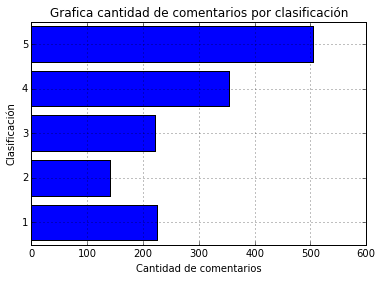

In [4]:
# Se importa la libreria para utilizar plot
# Además se plotea en el própio notebook y no como una ventana nueva
%matplotlib inline
from pylab import *

# Se realiza una gráfica de cantidad de comentarios en función de su clasificación
gruposCalificacion = datos.groupby([u'Calificación']).groups
keyClasificacion = gruposCalificacion.keys()
cantClasificacion = []
for k in keyClasificacion:
    cantClasificacion.append(len(gruposCalificacion.get(k)))    
pos = arange(len(keyClasificacion)) + 0.5 

figure(1)
barh(pos,cantClasificacion, align='center')
yticks(pos, keyClasificacion)
xlabel('Cantidad de comentarios')
ylabel(u'Clasificación')
title(u'Grafica cantidad de comentarios por clasificación')
grid(True)
show()

In [5]:
#Se imprime la cantidad de comentarios asociados a cada calse (es decir cantidad de comentarios por calificación)
print "\nCantidad de comentarios asociados a cada calificación:\n"
print datos.ix[:,7].value_counts()


Cantidad de comentarios asociados a cada calificación:

5    505
4    354
1    225
3    222
2    141
dtype: int64


In [6]:
print "A continuación se listan los atributos con su tipo asociado:\n"
print datos.dtypes

A continuación se listan los atributos con su tipo asociado:

Título          object
Año              int64
Estrellas        int64
Género          object
Duración        object
Reseña          object
ComTexto        object
Calificación     int64
ComFechaHora    object
dtype: object


In [7]:
# Se chequea si los atributos poseen o no valores faltantes
# Para ello se recorren todos los atributos (columnas de 'datos')
for atributo in datos.columns:
    
    # Se obtiene la cantidad de valores distinto de vacio del atributo 
    cantValoresAtributo = datos[atributo].describe()['count']
    
    # Si hay menos que la cantidad de comentarios de 'datos' -> hay valores faltantes
    if(cantComentarios > cantValoresAtributo):
        print "Hay valores faltantes para el atributo " + atributo
    else:
        print "No hay valores faltantes para el tributo " + atributo

No hay valores faltantes para el tributo Título
No hay valores faltantes para el tributo Año
No hay valores faltantes para el tributo Estrellas
No hay valores faltantes para el tributo Género
No hay valores faltantes para el tributo Duración
No hay valores faltantes para el tributo Reseña
No hay valores faltantes para el tributo ComTexto
No hay valores faltantes para el tributo Calificación
No hay valores faltantes para el tributo ComFechaHora


### 3. Descartamos columnas innecesarias
En esta sección se descartan las columnas (atributos) que se consideran innecesarios. En particular las columnas que creemos se consideran necesarias son solamente las columnas de los comentarios y los puntajes asociados a dichos comentarios. Por lo que se procede a eliminar el resto.

In [8]:
# Se descartan de 'datos' las columnas innecesarias, dejando solamente los comentarios y sus calificaciones
datos.drop(datos.columns[[0,1,2,3,4,5,8]],inplace=True,axis=1)

# Se imprime un resumen de los datos
print datos

                                               ComTexto  Calificación
0     Muchas gracias, vi online los primeros 4, lueg...             4
1           La mejor serie desde Los Soprano y The Wire             5
2     Llega un punto en el que aburre. Es un plato b...             2
3     En realidad no es una respuesta , es una corre...             1
4     Ahora entiendo menos. El libro en que se basa ...             1
5     Una pena desperdiciar un buen elenco y obviame...             1
6     MAGISTRAL!! excelente la recreación de época. ...             5
7                             es una película mui padre             5
8     EXCELENTE! GENIAL! Esperaba ir a ver con mi hi...             5
9     Muy, muy buena...para grandes y chicos. Tiene ...             5
10    Excelente película, muy original y divertida. ...             5
11    Muy buena película, muy graciosa y de humor ba...             4
12    Muy linda película. La fui a ver con mi hija, ...             4
13    Linda película

### 3. Preprocesamiento de los comentarios
El corpus sobre el cual se trabaja puede tener contener datos con ruido en su contenido. Es decir, diversos elementos que están mezclados en el contenido pero que además de no aportar nada a la tarea de clasificación, generan ruido dificultando las tareas posteriores. Para ello entonces se procede a realizar el preprocesamiento de los comentarios.

In [9]:
# En primera instancia se quitan los espacios en blanco al final y al principio (espacio, tab, retorno de carro, salto de linea)

# Se recorren los datos por filas
for i in range(0,len(datos)):
    
    # Se accede a la fila i columna 0 (es decir el valor comentario) y se lo modifica por el mismo modificado
    datos.ix[i,0] = datos.ix[i,0].strip(' \t\n\r')

In [10]:
# Luego se quitan las etiquetas html de los comentarios

# Se recorren los datos por filas
for i in range(0,len(datos)):
    
    # Se obtiene el largo del comentario i
    length = len(datos.ix[i,0])
    new_length = 0
    
    # Expresión regular para matchear etiquetas html
    reg = r'<\/?\w+((\s+\w+(\s*=\s*(?:".*?"|\'.*?\'|[^\'">\s]+))?)+\s*|\s*)\/?>'
    
    # Se aplica la expresión regular al comentario mientras cambien los largos
    while new_length != length:
        
        # Se cambia el comentario por el mismo sin etiquetas html
        datos.ix[i,0] = re.sub(reg, "", datos.ix[i,0])
        new_length = len(datos.ix[i,0])    

### 4. Tokenización
En esta sección se realiza el proceso de tokenización de los textos utilizando la biblioteca NLTK. Además se convierte a un formato suceptible para la clasificación. Es decir, se toquenizan los comentarios y se calcula el diccionario de palabras frecuentes del mismo. En base a ello y al valor de clasificación asociado se crea una tupla la cual corresponde al comentario analizado. Luego estas tuplas (una por cada comentario) son la entrada para el entrenamiento del algoritmo Entropía Máxima provisto por NLTK.

In [11]:
# Funcion que dado un numero entre (1 y 5) devuelve la clasificación asociada
# En este lab si es 5 o 4 -> positivo; 3 -> neutro; 1 o 0 -> negativo
def codificarClasificacion(num):
    if(num > 3):
        return "pos"
    elif(num == 3):
        return "neu"
    else:
        return "neg"

In [12]:
# Retorna una lista de tuplas. 
# Cada tupla posee un diccionario (dict) palabra-frecuencia del comentario y la clasificación asociada
# En otras palabras [(dict1, clasificacion1),(dict2, clasificacion2), ... ]

listaTuplas = []

# Se recorren los comentarios y para cada uno de ellos se tokeniza con nltk
for i in range(0,len(datos.ComTexto)):
    
    # Se crea el diccionario asociado al comentario
    dic = {}
    
    # Por cada palabra retornada de la tokenizacion del comentario
    for palabra in nltk.word_tokenize(datos.ix[i,0]):
        
        # Si la palabra está en el diccionario del comentario, se aumenta la frecuencia
        # En caso contrario se la pone en el diccionario con valor 1
        if(palabra.lower() in dic): 
            dic[palabra.lower()] = dic[palabra.lower()] + 1
        else:
            dic[palabra.lower()] = 1
            
    # Luego de tokenizado el comentario, se agrega una tupla a la lista que contendrá
    # el diccionario de frecuencias y la clasificaion asociada al comentario
    listaTuplas.insert(i,(dic,codificarClasificacion(datos.ix[i,1])))

In [13]:
# Para entender lo anterior

# Se imprime el primer comentario junto a su clasificacion
print datos.ix[0,:]

# Si todo esta bien al imprimir el primer elemento de la lista
# Se deberia ver el diccionario mas la clasificacion asociada al comentario 
print listaTuplas[0]

ComTexto        Muchas gracias, vi online los primeros 4, lueg...
Calificación                                                    4
Name: 0, dtype: object
({u'hbo': 1, u'gracias': 1, u'luego': 1, u'la': 1, u'vi': 1, u'segu\xed': 1, u',': 2, u'los': 1, u'primeros': 1, u'4': 1, u'por': 1, u'online': 1, u'muchas': 1}, 'pos')


### 5. Separamos entrenamiento y testeo 
Una vez de haber llegado a este punto tenemos los datos tokenizados en la variable listaTuplas. Habrá entonces que dividir dicha lista en conjuntos de entrenamiento y testeo, para primero entrenar el algoritmo y luego testearlo.
Para poder entrenar y testear un algoritmo de aprendizaje, como se mencionó, es necesario primero particionar los datos en dos conjuntos disjuntos de entrenamiento y testeo. Se separarán aleatoriamente un 20% de los datos para testeo y el 80% restante se utilizará para el entrenamiento. Para esto se utilizó la función train_test_split del paquete cross_validation de sklearn.

In [14]:
from sklearn.cross_validation import train_test_split

# Se divide el conjunto de datos en train (80%) y test (20%)
datos_train, datos_test = train_test_split(listaTuplas, test_size=0.2)

# Se chequean las cantidades de la división
print len(datos_train)
print len(datos_test)

1157
290


### 6. Se entrena el algoritmo de máxima entropia y se lo evalua
Una vez de tener los datos en un formato aceptable para los algoritmos de entrenamiento y particionado los mismos en test y train, se procede a realizar el entrenamiento del algoritmo de Máxima Entropía. Una vez realizado dicho entrenamiento se procede a evaluarlo.

In [25]:
# En la siguiente linea se entrena el algoritmo con 7 iteraciones
# Obs. El entrenamiento es bastante lento, habría que llegar a un valor de iteraciones adecuado
clf = nltk.classify.MaxentClassifier.train(datos_train,max_iter=7)

  ==> Training (1 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.09861        0.590
         Final          -0.80770        0.785


In [26]:
# Funcion que dada una distribución de probabilidad de las clasificaciones
# devuelve la clasificacion que tiene mayor probabilidad
def getClasificacion(pdist):
    
    # Se inicializa la clasificacion
    clasificacion = 0;
    prob = 0
    
    # Por cada clasificacion posible, la comparo con la inicializacion
    # Me quedo con la mas grande
    for i in range(1,6):
        if( pdist.prob(i) > prob):
            clasificacion = i
            prob = pdist.prob(i)

    return clasificacion

In [28]:
# Se define la variable de aciertos
aciertos = 0

# Para cada comentario del conjunto de testeo se evalua segun el algoritmo entrenado
for comentario in datos_test:
    
    # Se obtiene la clasificacion del algoritmo para el comentario
    clasificacion = getClasificacion(clf.prob_classify(comentario[0]))
    
    # En caso que la clasificacion sea la correcta se aumenta el acierto
    if(codificarClasificacion(clasificacion) == comentario[1]):
        aciertos += 1

tasa = float(acierto)/len(datos_test)
print "La tasa de acierto para el algoritmo es de: " + str(tasa)

La tasa de acierto para el algoritmo es de: 0.224137931034
